# EVERYTHING HERE COMES FROM THIS REPO -> https://github.com/dougsouza/face-frontalization

In [211]:
from deepface import DeepFace
from matplotlib import pyplot as plt
import cv2
import scipy.io as scio
import numpy as np
import mediapipe as mp
import supervision as sv
import os
import sys

In [212]:
src_path = os.path.abspath(os.path.join('../../../', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

## Trying out the face frontalization

In [213]:
TEST_IMAGE = "test_image2.jpg"
TEST_IMAGE_PATH = os.path.abspath(os.path.join('..', 'test_images', TEST_IMAGE))

### Getting the frontalization to work

In [214]:

class ThreeD_Model:
    def __init__(self, path, name):
        self.load_model(path, name)

    def load_model(self, path, name):
        model = scio.loadmat(path)[name]
        self.out_A = np.asmatrix(model['outA'][0, 0], dtype='float32') #3x3
        self.size_U = model['sizeU'][0, 0][0] #1x2
        self.model_TD = np.asarray(model['threedee'][0,0], dtype='float32') #68x3
        self.indbad = model['indbad'][0, 0]#0x1
        self.ref_U = np.asarray(model['refU'][0,0])

### load model

In [215]:
model3D = ThreeD_Model(src_path + "/models/frontalization_models/model3Ddlib.mat", 'model_dlib')

### Load query image

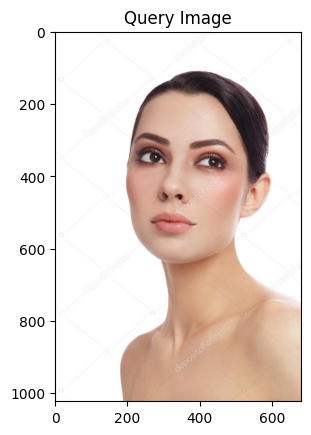

In [234]:
# load query image
img = cv2.imread(TEST_IMAGE_PATH, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Query Image')
plt.show()

### Get landmarks (dlib way)

In [235]:
import dlib

def _shape_to_np(shape):
    xy = []
    for i in range(68):
        xy.append((shape.part(i).x, shape.part(i).y,))
    xy = np.asarray(xy, dtype='float32')
    return xy

def get_landmarks(img):
    # if not automatically downloaded, get it from:
    # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
    predictor_path = src_path + "/models/frontalization_models/shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    lmarks = []
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))
    shapes = []
    for k, det in enumerate(dets):
        shape = predictor(img, det)
        shapes.append(shape)
        xy = _shape_to_np(shape)
        lmarks.append(xy)

    lmarks = np.asarray(lmarks, dtype='float32')
    return lmarks

In [236]:
lmarks = get_landmarks(img)[0]

Number of faces detected: 1


### get landmarks

In [ ]:
# VERTEX_COLOR = sv.Color.WHITE
# VERTEX_RADIUS = 1

# model = mp.solutions.face_mesh.FaceMesh(
#     static_image_mode=False,       # Set to True if working with still images
#     refine_landmarks=True,         # Enables more precise landmark detection (includes irises)
#     max_num_faces=1,               # Number of faces to detect
#     min_detection_confidence=0.5,  # Minimum detection confidence
#     min_tracking_confidence=0.5,   # Minimum tracking confidence
# )
# annotator = sv.VertexAnnotator(color=VERTEX_COLOR, radius=VERTEX_RADIUS)

In [ ]:
# image = cv2.imread(TEST_IMAGE_PATH)
# image = np.array(image)

In [ ]:
# resolution_wh = (image.shape[1], image.shape[0])
# processed_image = model.process(image)
# key_points = sv.KeyPoints.from_mediapipe(processed_image, resolution_wh)

In [201]:
# landmark_indices_68 = [
#     # Face outline - right
#     377, 378, 365, 397, 288, 361, 323, 454, 356, 368, 300, 283, 282, 295, 285,
#     # Face outline - left
#     148, 149, 136, 172, 58, 132, 93, 234, 127, 139, 156, 46, 53, 52, 65, 55,
#     # right eye
#     362, 385, 387, 263, 373, 380,
#     # left eye
#     33, 160, 158, 133, 153, 144,
#     # nose
#     168, 197, 5, 1, 2, 102, 240, 331, 460,
#     # upper lip
#     61, 62, 40, 37, 0, 267, 270, 291, 292,
#     # lower lip
#     91, 84, 17, 314, 321, 179, 403
# ]

# def extract_68_keypoints(key_points):
#     keypoints_68 = [key_points[i] for i in landmark_indices_68]
#     return np.array(keypoints_68, dtype='float32')

In [202]:
# lmarks = extract_68_keypoints(key_points.xy[0])

### display landmarks

68


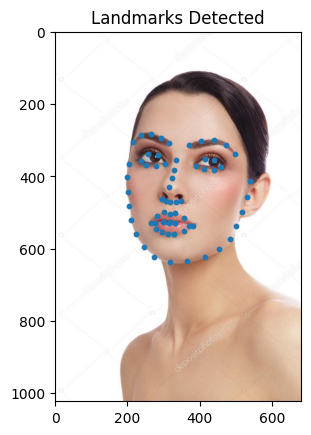

In [237]:
print(len(lmarks))
plt.figure()
plt.title('Landmarks Detected')
plt.imshow(img[:, :, ::-1])
plt.scatter(lmarks[:, 0], lmarks[:, 1], s=10)

### Get projection matrix

In [238]:
def estimate_camera(model3D, fidu_XY):
    rmat, tvec = calib_camera(model3D, fidu_XY)
    RT = np.hstack((rmat, tvec))
    projection_matrix = model3D.out_A * RT
    return projection_matrix, model3D.out_A, rmat, tvec


def calib_camera(model3D, fidu_XY):
    #compute pose using refrence 3D points + query 2D points
    ret, rvecs, tvec = cv2.solvePnP(model3D.model_TD, fidu_XY, model3D.out_A, None, None, None, False)
    rmat, jacobian = cv2.Rodrigues(rvecs, None)

    inside = calc_inside(model3D.out_A, rmat, tvec, model3D.size_U[0], model3D.size_U[1], model3D.model_TD)
    if(inside == 0):
        tvec = -tvec
        t = np.pi
        RRz180 = np.asmatrix([np.cos(t), -np.sin(t), 0, np.sin(t), np.cos(t), 0, 0, 0, 1]).reshape((3, 3))
        rmat = RRz180*rmat
    return rmat, tvec

def get_opengl_matrices(camera_matrix, rmat, tvec, width, height):
    projection_matrix = np.asmatrix(np.zeros((4,4)))
    near_plane = 0.0001
    far_plane = 10000

    fx = camera_matrix[0,0]
    fy = camera_matrix[1,1]
    px = camera_matrix[0,2]
    py = camera_matrix[1,2]

    projection_matrix[0, 0] = 2.0 * fx / width
    projection_matrix[1, 1] = 2.0 * fy / height
    projection_matrix[0, 2] = 2.0 * (px / width) - 1.0
    projection_matrix[1, 2] = 2.0 * (py / height) - 1.0
    projection_matrix[2, 2] = -(far_plane + near_plane) / (far_plane - near_plane)
    projection_matrix[3, 2] = -1
    projection_matrix[2, 3] = -2.0 * far_plane * near_plane / (far_plane - near_plane)

    deg = 180
    t = deg*np.pi/180.
    RRz=np.asmatrix([np.cos(t), -np.sin(t), 0, np.sin(t), np.cos(t), 0, 0, 0, 1]).reshape((3, 3))
    RRy=np.asmatrix([np.cos(t), 0, np.sin(t), 0, 1, 0, -np.sin(t), 0, np.cos(t)]).reshape((3, 3))
    rmat=RRz*RRy*rmat

    mv = np.asmatrix(np.zeros((4, 4)))
    mv[0:3, 0:3] = rmat
    mv[0, 3] = tvec[0]
    mv[1, 3] = -tvec[1]
    mv[2, 3] = -tvec[2]
    mv[3, 3] = 1.
    return mv, projection_matrix


def extract_frustum(camera_matrix, rmat, tvec, width, height):
    mv, proj = get_opengl_matrices(camera_matrix, rmat, tvec, width, height)
    clip = proj * mv
    frustum = np.asmatrix(np.zeros((6 ,4)))
    #/* Extract the numbers for the RIGHT plane */
    frustum[0, :] = clip[3, :] - clip[0, :]
    #/* Normalize the result */
    v = frustum[0, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[0, :] = frustum[0, :]/t

    #/* Extract the numbers for the LEFT plane */
    frustum[1, :] = clip[3, :] + clip[0, :]
    #/* Normalize the result */
    v = frustum[1, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[1, :] = frustum[1, :]/t

    #/* Extract the BOTTOM plane */
    frustum[2, :] = clip[3, :] + clip[1, :]
    #/* Normalize the result */
    v = frustum[2, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[2, :] = frustum[2, :]/t

    #/* Extract the TOP plane */
    frustum[3, :] = clip[3, :] - clip[1, :]
    #/* Normalize the result */
    v = frustum[3, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[3, :] = frustum[3, :]/t

    #/* Extract the FAR plane */
    frustum[4, :] = clip[3, :] - clip[2, :]
    #/* Normalize the result */
    v = frustum[4, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[4, :] = frustum[4, :]/t

    #/* Extract the NEAR plane */
    frustum[5, :] = clip[3, :] + clip[2, :]
    #/* Normalize the result */
    v = frustum[5, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[5, :] = frustum[5, :]/t
    return frustum


def calc_inside(camera_matrix, rmat, tvec, width, height, obj_points):
    frustum = extract_frustum(camera_matrix, rmat, tvec, width, height)
    inside = 0
    for point in obj_points:
        if(point_in_frustum(point[0], point[1], point[2], frustum) > 0):
            inside += 1
    return inside


def point_in_frustum(x, y, z, frustum):
    for p in range(0, 3):
        if(frustum[p, 0] * x + frustum[p, 1] * y + frustum[p, 2] + z + frustum[p, 3] <= 0):
            return False
    return True

In [239]:
proj_matrix, camera_matrix, rmat, tvec = estimate_camera(model3D, lmarks)

### Load mask to exclude eyes from symmetry

In [240]:
eyemask = np.asarray(scio.loadmat(src_path + "/models/frontalization_models/eyemask.mat")['eyemask'])

### Perform frontalization

In [241]:
def frontalize(img, proj_matrix, ref_U, eyemask):
    ACC_CONST = 800
    img = img.astype('float32')
    print("query image shape:", img.shape)

    bgind = np.sum(np.abs(ref_U), 2) == 0
    # count the number of times each pixel in the query is accessed
    threedee = np.reshape(ref_U, (-1, 3), order='F').transpose()
    temp_proj = proj_matrix * np.vstack((threedee, np.ones((1, threedee.shape[1]))))
    temp_proj2 = np.divide(temp_proj[0:2, :], np.tile(temp_proj[2, :], (2,1)))

    bad = np.logical_or(temp_proj2.min(axis=0) < 1, temp_proj2[1, :] > img.shape[0])
    bad = np.logical_or(bad, temp_proj2[0, :] > img.shape[1])
    bad = np.logical_or(bad, bgind.reshape((-1), order='F'))
    bad = np.asarray(bad).reshape((-1), order='F')

    temp_proj2 -= 1

    badind = np.nonzero(bad > 0)[0]
    temp_proj2[:,badind] = 0

    ind = np.ravel_multi_index((np.asarray(temp_proj2[1, :].round(), dtype='int64'), np.asarray(temp_proj2[0, :].round(), dtype='int64')), dims=img.shape[:-1], order='F')

    synth_frontal_acc = np.zeros(ref_U.shape[:-1])
    ind_frontal = np.arange(0, ref_U.shape[0]*ref_U.shape[1])

    c, ic = np.unique(ind, return_inverse=True)
    bin_edges = np.r_[-np.Inf, 0.5 * (c[:-1] + c[1:]), np.Inf]
    count, bin_edges = np.histogram(ind, bin_edges)
    synth_frontal_acc = synth_frontal_acc.reshape(-1, order='F')
    synth_frontal_acc[ind_frontal] = count[ic]
    synth_frontal_acc = synth_frontal_acc.reshape((320, 320), order='F')
    synth_frontal_acc[bgind] = 0
    synth_frontal_acc = cv2.GaussianBlur(synth_frontal_acc, (15, 15), 30., borderType=cv2.BORDER_REPLICATE)

    #remap
    mapX = temp_proj2[0,:].astype(np.float32)
    mapY = temp_proj2[1,:].astype(np.float32)

    mapX = np.reshape(mapX,(-1,320), order = 'F')
    mapY = np.reshape(mapY,(-1,320), order = 'F')

    frontal_raw = cv2.remap(img, mapX, mapY, cv2.INTER_CUBIC)

    frontal_raw = frontal_raw.reshape((-1,3), order = 'F')
    frontal_raw[badind,:] = 0
    frontal_raw = frontal_raw.reshape((320, 320, 3), order = 'F')

    # which side has more occlusions?
    midcolumn = int(np.round(ref_U.shape[1]/2))
    sumaccs = synth_frontal_acc.sum(axis=0)
    sum_left = sumaccs[0:midcolumn].sum()
    sum_right = sumaccs[midcolumn+1:].sum()
    sum_diff = sum_left - sum_right

    if np.abs(sum_diff) > ACC_CONST: # one side is ocluded
        ones = np.ones((ref_U.shape[0], midcolumn))
        zeros = np.zeros((ref_U.shape[0], midcolumn))
        if sum_diff > ACC_CONST: # left side of face has more occlusions
            weights = np.hstack((zeros, ones))
        else: # right side of face has more occlusions
            weights = np.hstack((ones, zeros))
        weights = cv2.GaussianBlur(weights, (33, 33), 60.5, borderType=cv2.BORDER_REPLICATE)

        # apply soft symmetry to use whatever parts are visible in ocluded side
        synth_frontal_acc /= synth_frontal_acc.max()
        weight_take_from_org = 1. / np.exp(0.5+synth_frontal_acc)
        weight_take_from_sym = 1 - weight_take_from_org

        weight_take_from_org = np.multiply(weight_take_from_org, np.fliplr(weights))
        weight_take_from_sym = np.multiply(weight_take_from_sym, np.fliplr(weights))

        weight_take_from_org = np.tile(weight_take_from_org.reshape(320, 320, 1), (1, 1, 3))
        weight_take_from_sym = np.tile(weight_take_from_sym.reshape(320, 320, 1), (1, 1, 3))
        weights = np.tile(weights.reshape(320, 320, 1), (1, 1, 3))

        denominator = weights + weight_take_from_org + weight_take_from_sym
        frontal_sym = np.multiply(frontal_raw, weights) + np.multiply(frontal_raw, weight_take_from_org) + np.multiply(np.fliplr(frontal_raw), weight_take_from_sym)
        frontal_sym = np.divide(frontal_sym, denominator)

        # exclude eyes from symmetry
        frontal_sym = np.multiply(frontal_sym, 1-eyemask) + np.multiply(frontal_raw, eyemask)
        frontal_raw[frontal_raw > 255] = 255
        frontal_raw[frontal_raw < 0] = 0
        frontal_raw = frontal_raw.astype('uint8')
        frontal_sym[frontal_sym > 255] = 255
        frontal_sym[frontal_sym < 0] = 0
        frontal_sym = frontal_sym.astype('uint8')
    else: # both sides are occluded pretty much to the same extent -- do not use symmetry
        frontal_sym = frontal_raw
    return frontal_raw, frontal_sym

In [242]:
frontal_raw, frontal_sym = frontalize(img, proj_matrix, model3D.ref_U, eyemask)

query image shape: (1023, 682, 3)


### Display results

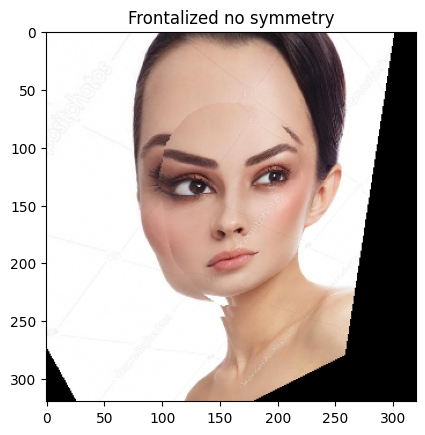

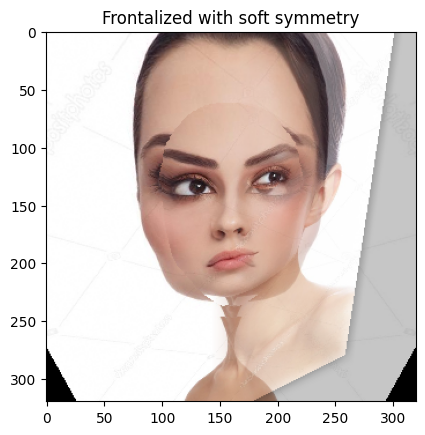

In [243]:
plt.figure()
plt.title('Frontalized no symmetry')
plt.imshow(frontal_raw[:, :, ::-1])
plt.figure()
plt.title('Frontalized with soft symmetry')
plt.imshow(frontal_sym[:, :, ::-1])
plt.show()